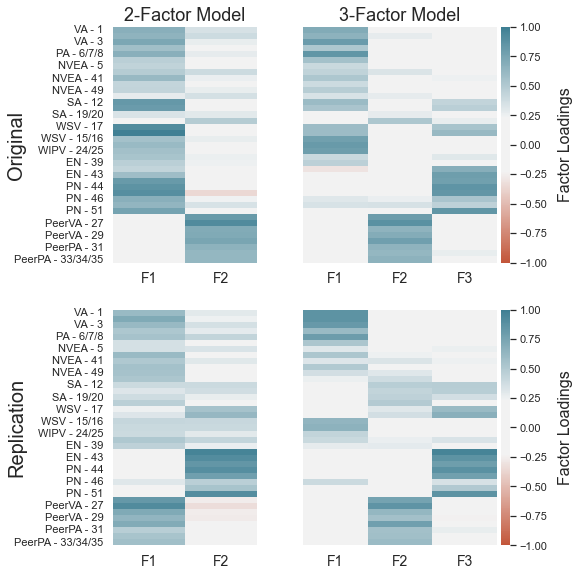

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from os.path import dirname
from pandas import Categorical, DataFrame, concat, read_csv
from mpl_toolkits.axes_grid1 import make_axes_locatable
# ROOT_DIR = dirname(dirname(os.path.realpath(__file__)))
sns.set_theme(context='notebook', style='white', font='sans-serif', font_scale=1.33)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define data parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define LD item pairs.
ld = [[6,7,8], [9,10,11], [13,14], [15,16], [19,20], [21,22,23], [24,25], [33,34,35], [36,37]]

## Define item ordering.
order = ['VA','PA','NVEA','SA','WSV','WIPV','EN','PN','PeerVA','PeerPA']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare design matrix.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)

## Collapse across LD items.
for ix in ld: 
    design = design.drop(index=ix[1:])
    design = design.rename(index={ix[0]:'/'.join(['%s' %i for i in ix])})

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define plot variables.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define palette.
cmap = sns.diverging_palette(20, 220, sep=60, as_cmap=True)

## Define labels.
ylabels = ['Original','Replication']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(8,8))

## Define layouts.
gs = [
    fig.add_gridspec(2, 1, left=0.20, right=0.45, top=0.95, bottom=0.05, hspace=0.20, wspace=0),
    fig.add_gridspec(2, 1, left=0.53, right=0.89, top=0.95, bottom=0.05, hspace=0.20, wspace=0)
]

for i, study in enumerate(['teicher2015','tuominen2022']):
        
    for j, f in enumerate([2,3]):
        
        ## Load factor loadings.
        fout = 'stan_results/%s/efa_f%s_cf-quartimax.csv' %(study, f)        
        loadings = read_csv(fout, index_col=0)
        
        ## Re-sort columns.
        loadings = loadings[loadings.columns[np.argsort(loadings.values[0])][::-1]]
        
        ## Convert to DataFrame.
        loadings.insert(0, 'item', design.index)
        loadings.insert(1, 'subscale', np.sort(order)[np.where(design[np.sort(order)])[-1]])
        
        ## Sort DataFrame.
        loadings['subscale'] = Categorical(loadings.subscale, categories=order, ordered=True)
        loadings = loadings.sort_values(['subscale','item']).set_index(['subscale','item'])
        
        ## Initialize axis.
        ax = plt.subplot(gs[j][i])
        
        ## Handle colorbar.
        if j: 
            cbar = True
            divider = make_axes_locatable(ax)
            cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
        else:
            cbar = False
            cbar_ax = None
        
        ## Plot loadings.
        sns.heatmap(loadings, vmin=-1, vmax=1, center=0, cmap=cmap, cbar=cbar, ax=ax, cbar_ax=cbar_ax)
        
        ## Add detail.
        ax.set(ylabel='', yticks=np.arange(0,39,2)+0.5, yticklabels=[])
        ax.set_xticklabels([f'F{i+1}' for i in range(f)], fontsize=14)
        if not j: ax.set_yticklabels([f'{k} - {v}' for k, v in loadings.index][::2], fontsize=11)
        if not j: ax.set_ylabel(ylabels[i], fontsize=20, labelpad=-12)
        if not i: ax.set_title(f'{f}-Factor Model', fontsize=18)
            
        ## Update colorbar.
        if cbar:
            cbar = ax.collections[0].colorbar
            cbar.set_label(r'Factor Loadings', fontsize=16, labelpad=10)
            cbar.ax.tick_params(labelsize=11) 
            
plt.savefig(os.path.join('figures', 'fig03.png'), dpi=100)